In [2]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from cpgan import init_yaml
from cpgan.eval.models_lib.ex6 import generator
import pandas as pd
from cpgan.ooppnm import img_process
from cpgan.ooppnm import pnm_sim
from cpgan.ooppnm import pnm_sim_old
import seaborn as sns 


import random
import porespy as ps
# random.seed(10)
# np.random.seed(10)

def kr_simulation(img_input,sim_num=100):
    data_pnm = pnm_sim.Pnm_sim(im=img_input)
    data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    data_pnm.init_physics()
    data_pnm.invasion_percolation()
    df_kr = data_pnm.kr_simulation(Snwp_num=sim_num)
    data_pnm.close_ws()
    return df_kr

def kabs_sim(img):
    data_pnm = pnm_sim_old.Pnm_sim(im=img)
    data_pnm.network_extract()
    if data_pnm.error == 1:
        return None
    data_pnm.init_physics()
    kabs = data_pnm.get_absolute_perm()
    data_pnm.close_ws()
    return kabs, data_pnm.data_tmp

def imgshow(im,sample_idx,z_idx):
    f = plt.figure()
    plt.imshow(im[sample_idx,0,z_idx,::])
    plt.show()

def plt_hist(fake,real,range_input,xlabel):
    # range input should be list
    f = plt.figure()
    plt.hist(real,range=range_input,density=True,bins=20,alpha=0.4,edgecolor='black',label='Original')
    plt.hist(fake,range=range_input,density=True,bins=20,alpha=0.4,edgecolor='black',label='Synthetic')
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

def plt_scatter(fake,real,range_input,xlabel):
    # range input should be list
    f = plt.figure()
    plt.scatter(real,fake)
    plt.xlim(range_input)
    plt.ylim(range_input)
    plt.xlabel("Original "+xlabel)
    plt.ylabel("Synthetic "+xlabel)
    plt.show()

def box_plot(fake,real,ylabel):
    phi_box = [fake, real]
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_axes([0, 0, 1, 1])

    bp = ax.boxplot(
        phi_box,
        boxprops=dict(linestyle='-', linewidth=2),
        whiskerprops=dict(linestyle='-', linewidth=2), 
        medianprops=dict(linestyle='-', linewidth=2), 
        capprops=dict(linestyle='-', linewidth=2)
            )

    ax.set_xticks([1,2],['Synthetic','Original'])
    ax.set_ylabel(ylabel)
    plt.show()

ex = 6
epoch = 20

# load model and features
f_yaml = init_yaml.yaml_f
gen_path = os.path.join(f_yaml['model'],"ex{}/cganex{}-{}.pth".format(ex,ex,epoch))
feature_path = os.path.join(f_yaml['feature_path'],'features.csv')
img_path = f_yaml['img_path']['img_chunk']

df = pd.read_csv(feature_path)
gen = generator.Generator(z_dim=200)
gen.load_state_dict(torch.load(gen_path,map_location=torch.device('cpu')))
gen.eval()

# load the simulation data for comparison
fake_data = pd.read_csv('post_sim_data/df_fakeold_{}.csv'.format(ex))
real_data = pd.read_csv('post_sim_data/df_realold_{}.csv'.format(ex))

sample_num = min(len(fake_data),len(real_data))
fake_data = fake_data.sample(sample_num)
real_data = real_data.sample(sample_num)

In [3]:
real_data.corr()

/tmp/ipykernel_29227/818856609.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  real_data.corr()


,kabs,phi,eul,spec_area,psd,tsd,coord
kabs,1.000000,0.782755,-0.289798,0.502206,0.649501,0.653634,0.107768
phi,0.782755,1.000000,-0.529576,0.797730,0.672233,0.602268,0.081233
eul,-0.289798,-0.529576,1.000000,-0.765033,-0.247514,0.030073,0.006471
spec_area,0.502206,0.797730,-0.765033,1.000000,0.359801,0.153097,0.073319
psd,0.649501,0.672233,-0.247514,0.359801,1.000000,0.689452,0.085964
tsd,0.653634,0.602268,0.030073,0.153097,0.689452,1.000000,0.066356
coord,0.107768,0.081233,0.006471,0.073319,0.085964,0.066356,1.000000


In [4]:
fake_data.corr()

,kabs,phi,eul,spec_area,psd,tsd,coord
kabs,1.000000,0.767334,-0.282697,0.359562,0.560350,0.623860,0.680820
phi,0.767334,1.000000,-0.499412,0.661230,0.620268,0.633046,0.845177
eul,-0.282697,-0.499412,1.000000,-0.791203,-0.231656,0.039435,-0.638132
spec_area,0.359562,0.661230,-0.791203,1.000000,0.165585,-0.042656,0.634446
psd,0.560350,0.620268,-0.231656,0.165585,1.000000,0.727867,0.691786
tsd,0.623860,0.633046,0.039435,-0.042656,0.727867,1.000000,0.489575
coord,0.680820,0.845177,-0.638132,0.634446,0.691786,0.489575,1.000000


#### Try to evaluate GAN at different training stages

* correlation matrix heatmap

/tmp/ipykernel_29227/2331339050.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = real_data.corr()


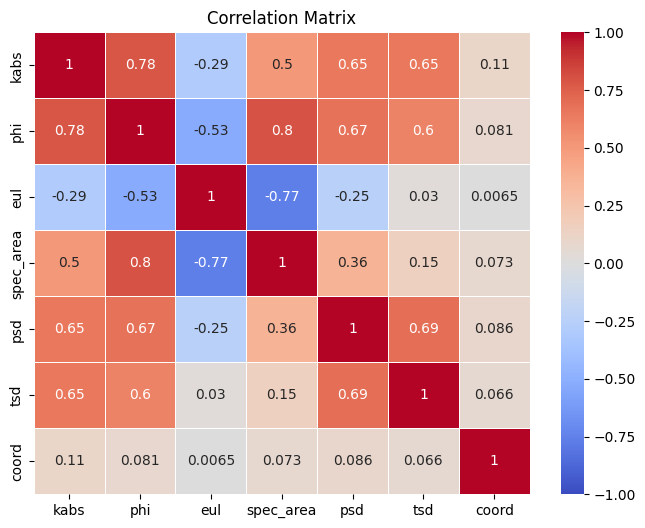

In [5]:
correlation_matrix = real_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

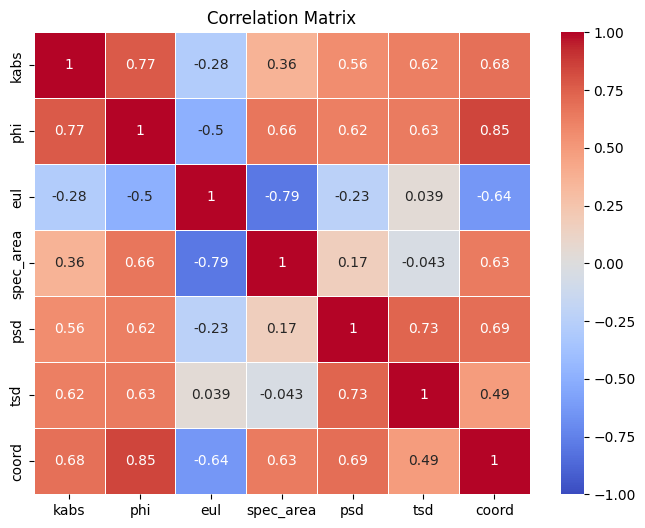

In [7]:
correlation_matrix = fake_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

#### box plot of reconstructed statistics vs training image statistics

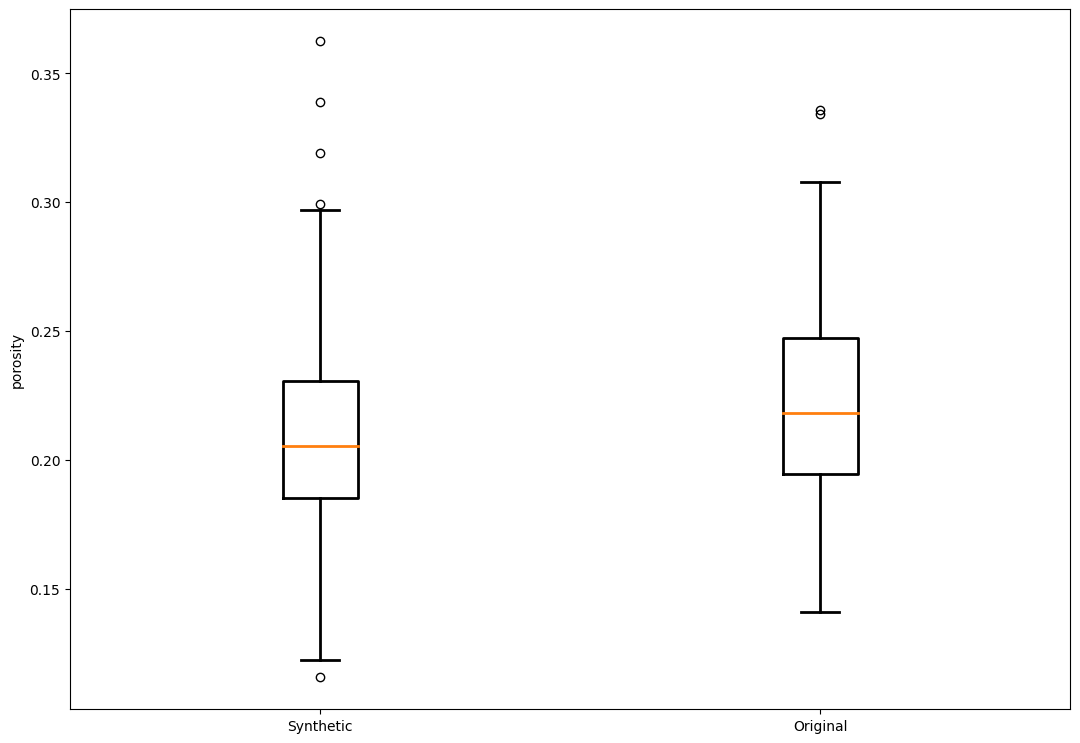

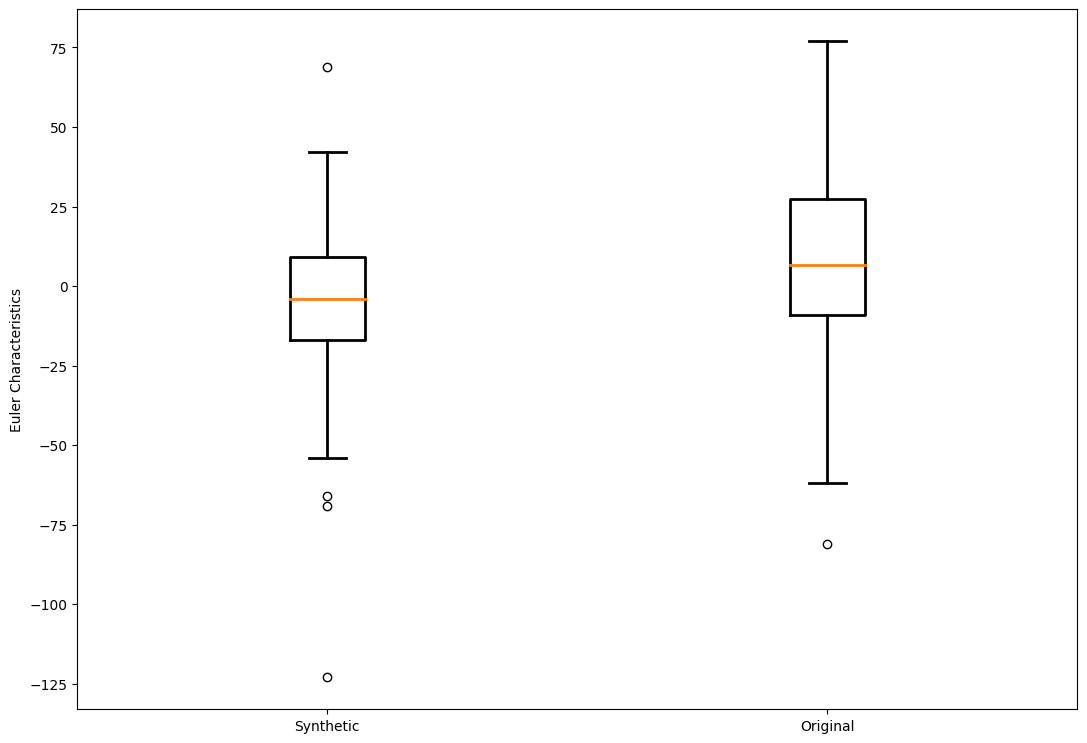

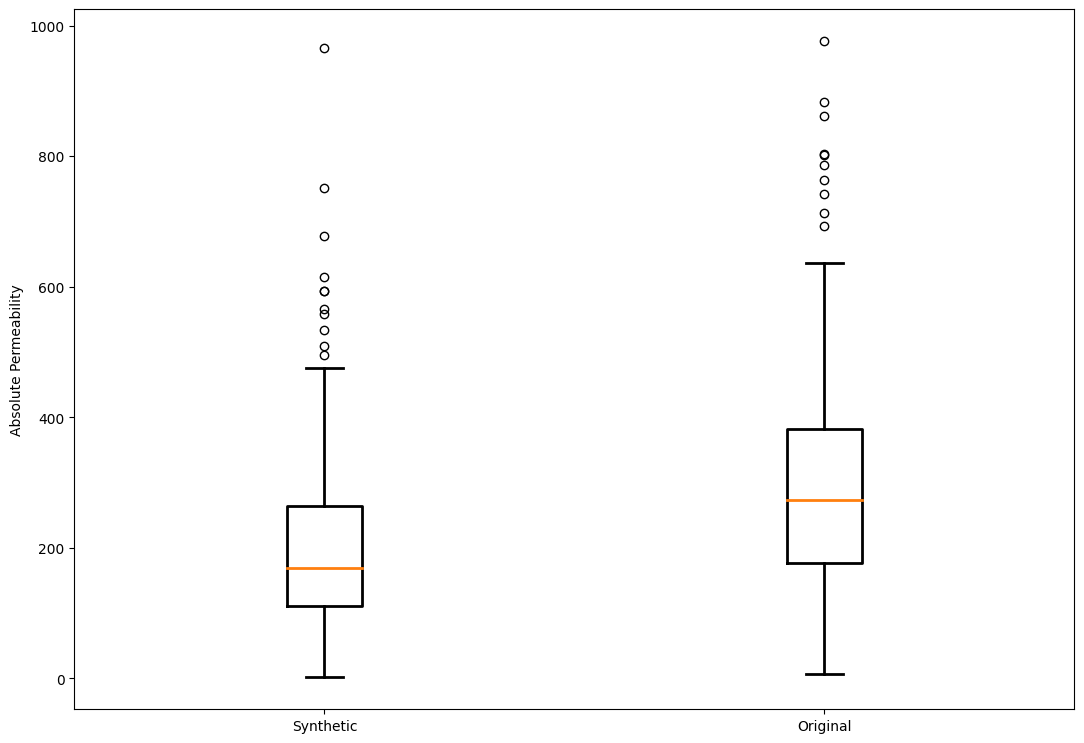

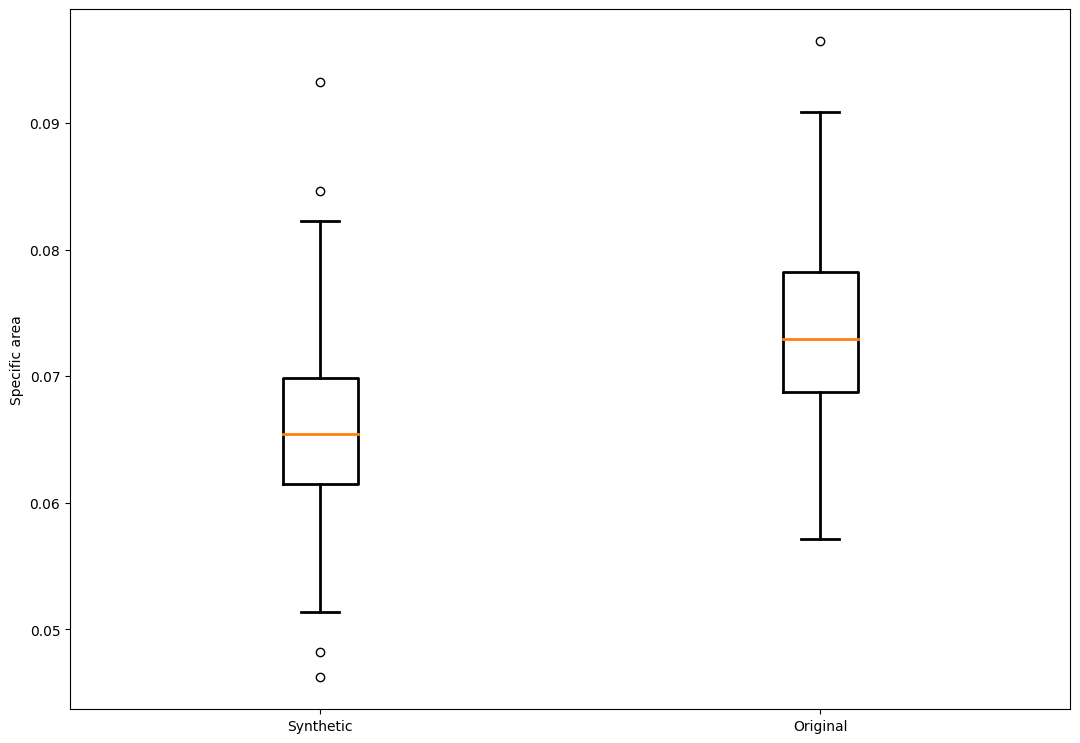

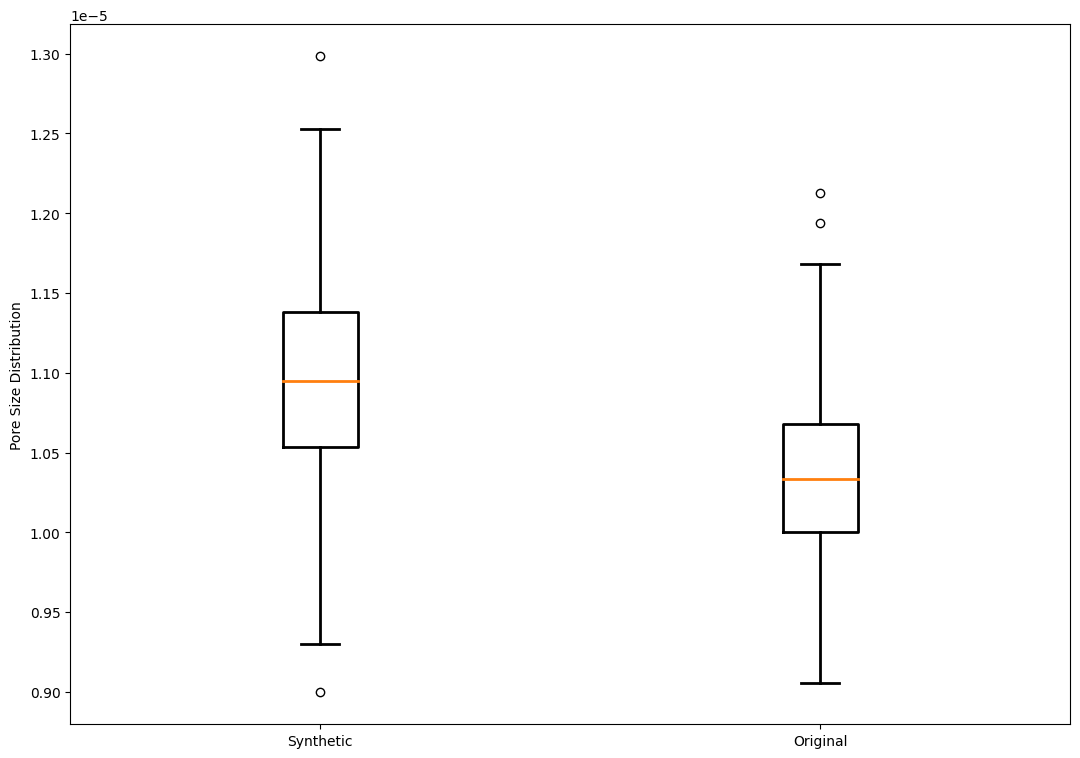

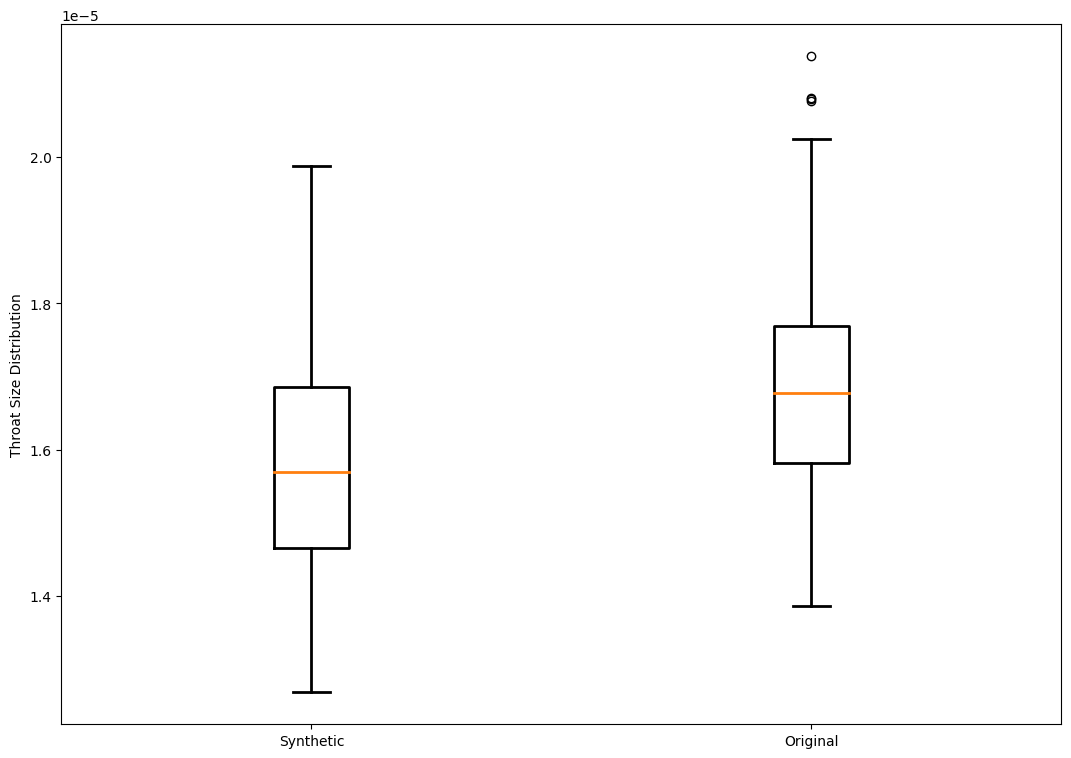

In [8]:
box_plot(fake_data['phi'].values,real_data['phi'].values,'porosity')
box_plot(fake_data['eul'].values,real_data['eul'].values,'Euler Characteristics')
box_plot(fake_data['kabs'].values,real_data['kabs'].values,'Absolute Permeability')
box_plot(fake_data['spec_area'].values,real_data['spec_area'].values,'Specific area')
box_plot(fake_data['psd'].values,real_data['psd'].values,'Pore Size Distribution')
box_plot(fake_data['tsd'].values,real_data['tsd'].values,'Throat Size Distribution')

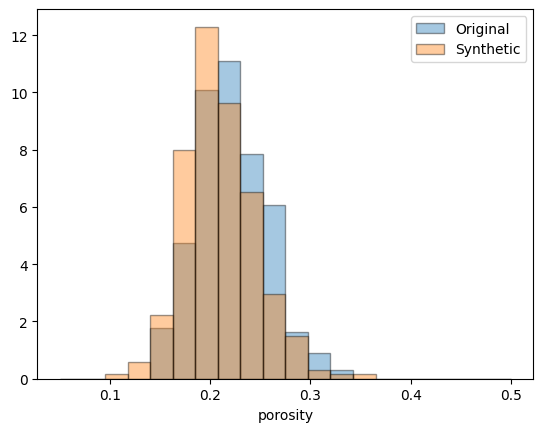

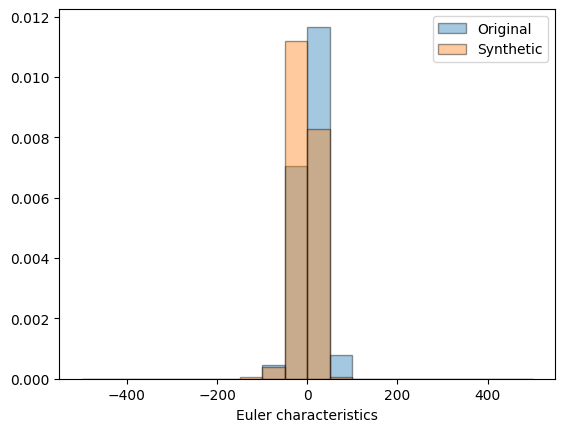

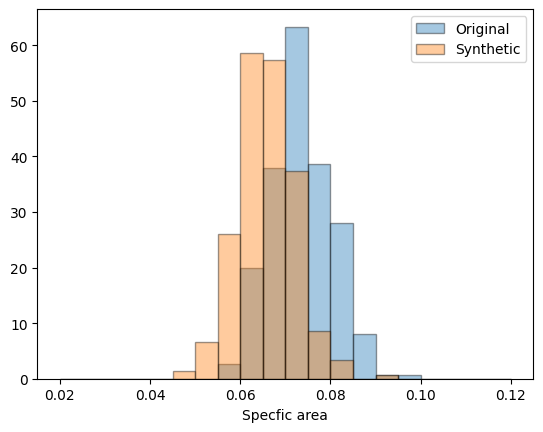

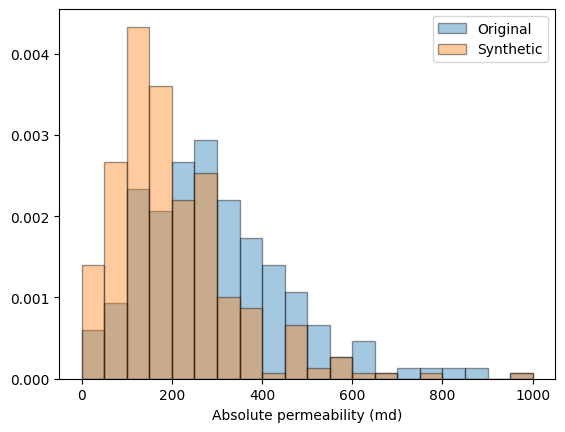

In [18]:
img_prc = img_process.Image_process()
plt_hist(
    fake_data['phi'].to_list(),real_data['phi'].to_list(),[0.05,0.5],'porosity'
    )

plt_hist(
    fake_data['eul'].to_list(),real_data['eul'].to_list(),[-500,500],'Euler characteristics'
)

plt_hist(
    fake_data['spec_area'].to_list(),real_data['spec_area'].to_list(),[0.02,0.12],'Specfic area'
)

plt_hist(
    fake_data['kabs'].to_list(),real_data['kabs'].to_list(),[0,1000],'Absolute permeability (md)'
)

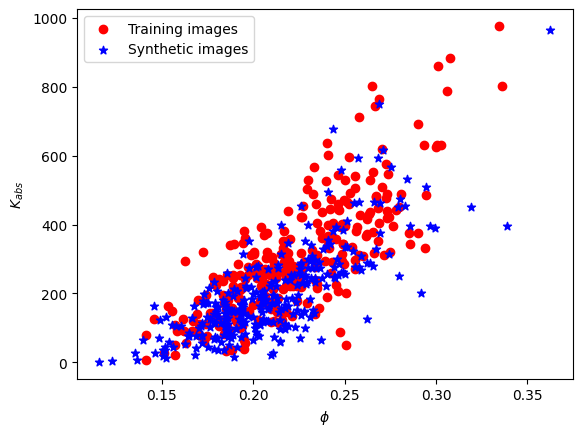

In [2]:
plt.scatter(real_data['phi'],real_data['kabs'],marker='o',c='r',label='Training images')
plt.scatter(fake_data['phi'],fake_data['kabs'],marker='*',c='b',label='Synthetic images')
plt.xlabel('$\phi$')
plt.ylabel('$K_{abs}$')
plt.legend()

#### Compare between fake vs real

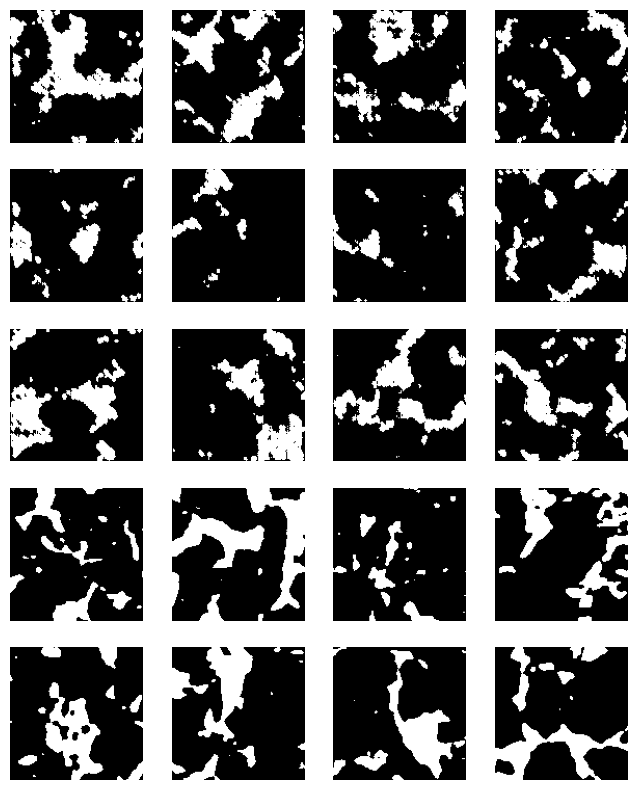

In [9]:
import random
def generate_img(sample_num):
    img=img_prc.clean_img(gen(torch.randn(sample_num,200)))
    return [img[i] for i in range(len(img))]

img_prc = img_process.Image_process()

f_yaml = init_yaml.yaml_f['img_path']['img_chunk']
PATH_img = [os.path.join(f_yaml,x) for x  in os.listdir(f_yaml)[:10000]]
random.shuffle(PATH_img)
real= [np.load(x) for x in PATH_img[:4]]
real1 = [np.load(x) for x in PATH_img[5:9]]

img_space = [generate_img(4),generate_img(4),generate_img(4),real1,real]
num_row = len(img_space)
num_col = 4

fig,axs = plt.subplots(num_row,num_col,figsize=(8,10))

for i in range(num_row):
    img_list = img_space[i]
    for j in range(num_col):
        img_sample = img_list[j][::,0]
        axs[i,j].imshow(img_sample,cmap='gray')
        axs[i,j].axis('off')

plt.show()